In [1]:
!tar -xzf images.tgz

In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.applications import VGG16, MobileNetV2

from tensorflow_addons.metrics import F1Score

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Dataset Functions

In [3]:
def normalize_image(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images/",
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    batch_size=32,
    image_size=(90, 90),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
).map(normalize_image).shuffle(4470)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images/",
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    batch_size=32,
    image_size=(90, 90),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
).map(normalize_image)


Found 5587 files belonging to 2 classes.
Using 4470 files for training.
Found 5587 files belonging to 2 classes.
Using 1117 files for validation.


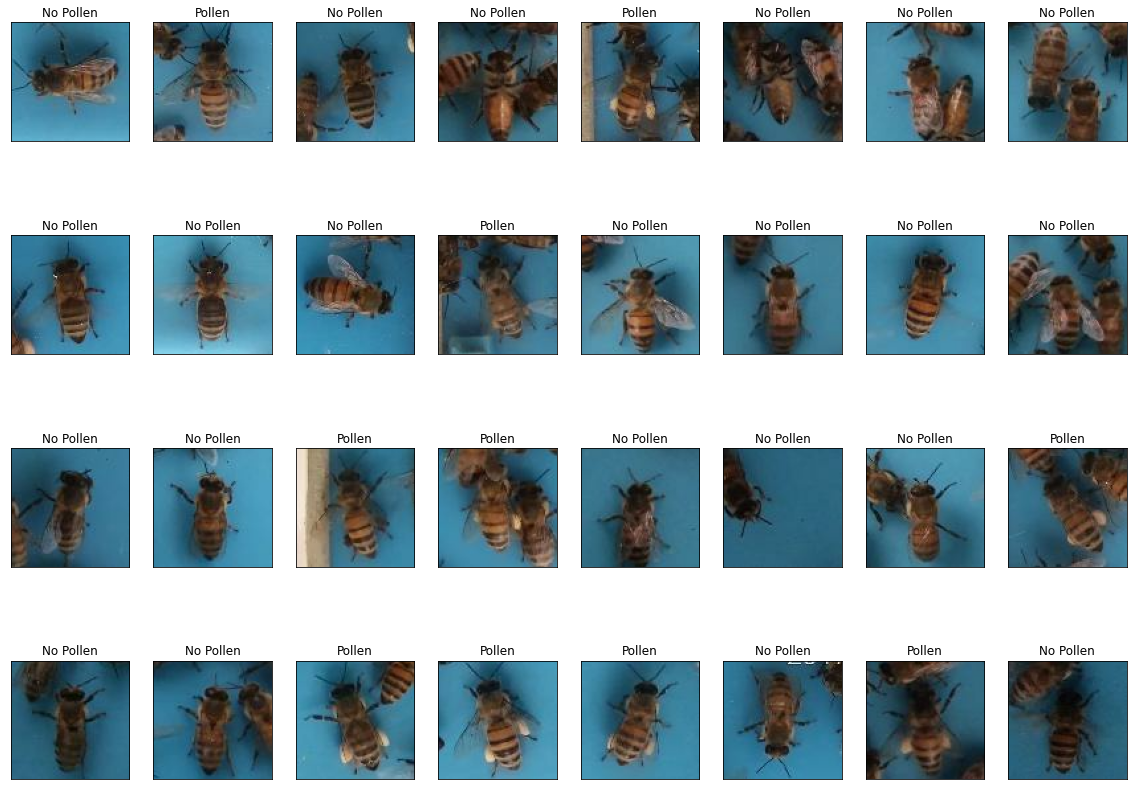

In [4]:
fig, ax = plt.subplots(4, 8, figsize=(20, 15))
axes = ax.ravel()

gen = iter(train_dataset)
sample_batch = next(gen)

for i, (image, label) in enumerate(zip(sample_batch[0], sample_batch[1])):
    axes[i].imshow(image)
    label_str = "Pollen" if label[0] else "No Pollen"
    axes[i].set_title("{}".format(label_str))
    axes[i].set_xticks([])
    axes[i].set_yticks([])

## Model Functions

In [5]:
class Classifier(tf.keras.Model):
    def __init__(self, base_model, filters=64, classes=2):
        super(Classifier, self).__init__()
        self.backbone = base_model
        self.flatten = Flatten(name='flatten')
        self.dense = Dense(filters,activation='relu')
        if classes == 1:
            self.classifier = Dense(classes, activation="sigmoid")
        else:
            self.classifier = Dense(classes, activation="softmax")
        self.model_name = "Classifier"
        
    def call(self, data):
        x = data
        x = self.backbone(x)
        x = self.flatten(x)
        x = self.dense(x)
        id_class = self.classifier(x)
        return id_class

### MobileNetV2

In [6]:
backbone = MobileNetV2(include_top=False, input_shape=(90, 90, 3))
model = Classifier(backbone, classes=1)

In [7]:
model.compile(loss='binary_crossentropy', optimizer="sgd",metrics=['accuracy', F1Score(num_classes=1, threshold=0.5)])

In [8]:
history = model.fit(train_dataset, epochs=1, validation_data=valid_dataset)
history_df = pd.DataFrame(history.history, index=history.epoch)

140/140 [==============================] - 10s 71ms/step - loss: 0.2405 - accuracy: 0.9049 - f1_score: 0.7889 - val_loss: 0.7524 - val_accuracy: 0.7762 - val_f1_score: 0.1438


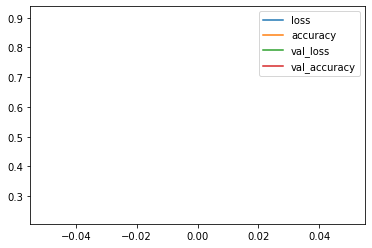

In [9]:
history_df.plot();

In [13]:
y_pred = []  # store predicted labels
y_true = []  # store true labels
X_valid = []

for image_batch, label_batch in valid_dataset:
    X_valid.append(image_batch)
    
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(preds)

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
images = tf.concat([item for item in X_valid], axis = 0)

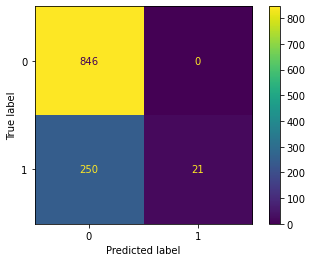

In [14]:
cm = confusion_matrix(correct_labels, predicted_labels > 0.5)
ConfusionMatrixDisplay(cm).plot()

In [15]:
print(classification_report(correct_labels, predicted_labels > 0.5 ))

              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       846
         1.0       1.00      0.08      0.14       271

    accuracy                           0.78      1117
   macro avg       0.89      0.54      0.51      1117
weighted avg       0.83      0.78      0.69      1117



In [63]:
model.save("pollen_model.tf")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: pollen_model.tf/assets


#### Check Predictions

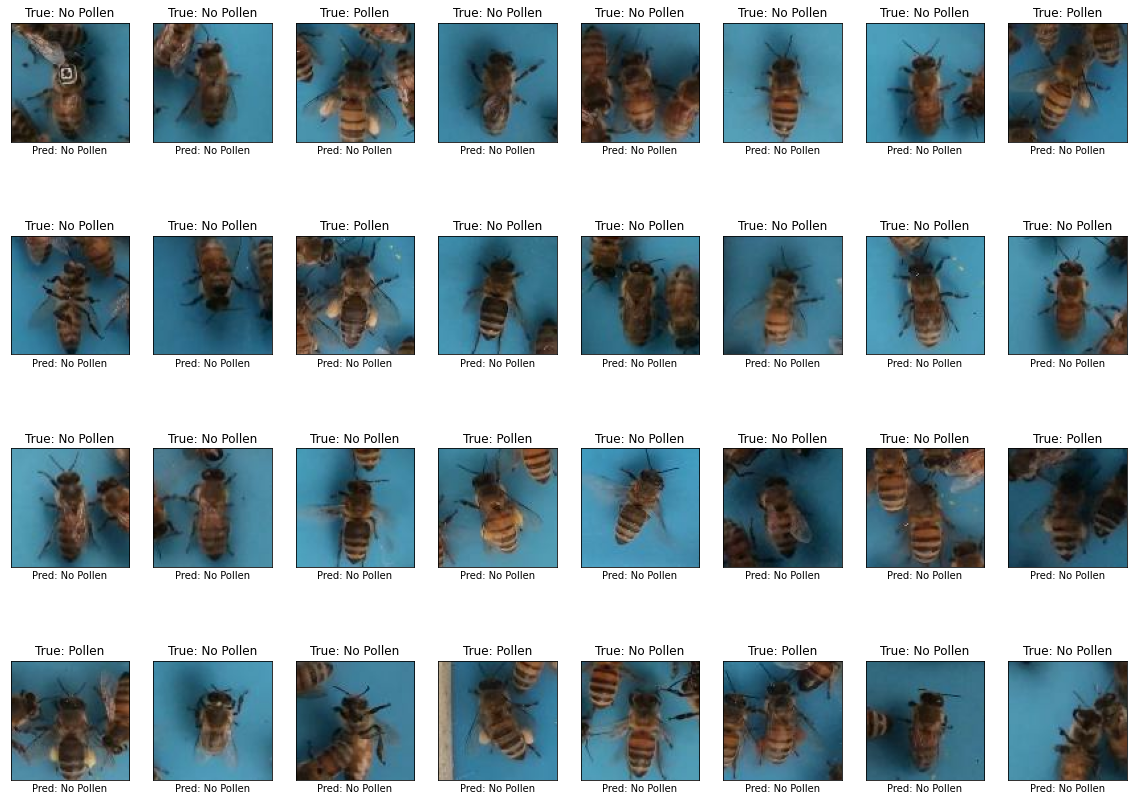

In [36]:
random_idx = np.random.permutation(len(images))
random_idx = random_idx[:32]
fig, ax = plt.subplots(4, 8, figsize=(20, 15))
axes = ax.ravel()

for i, idx in enumerate(random_idx):
    axes[i].imshow(images[idx])
    true_label = "Pollen" if correct_labels[idx] > 0.5 else "No Pollen"
    pred_label = "Pollen" if predicted_labels[idx] > 0.5 else "No Pollen"
    
    title = true_label + pred_label
    axes[i].set_title("True: {}".format(true_label))
    axes[i].set_xlabel("Pred: {}".format(pred_label))
    axes[i].set_xticks([])
    axes[i].set_yticks([])

#### Check Hard Cases

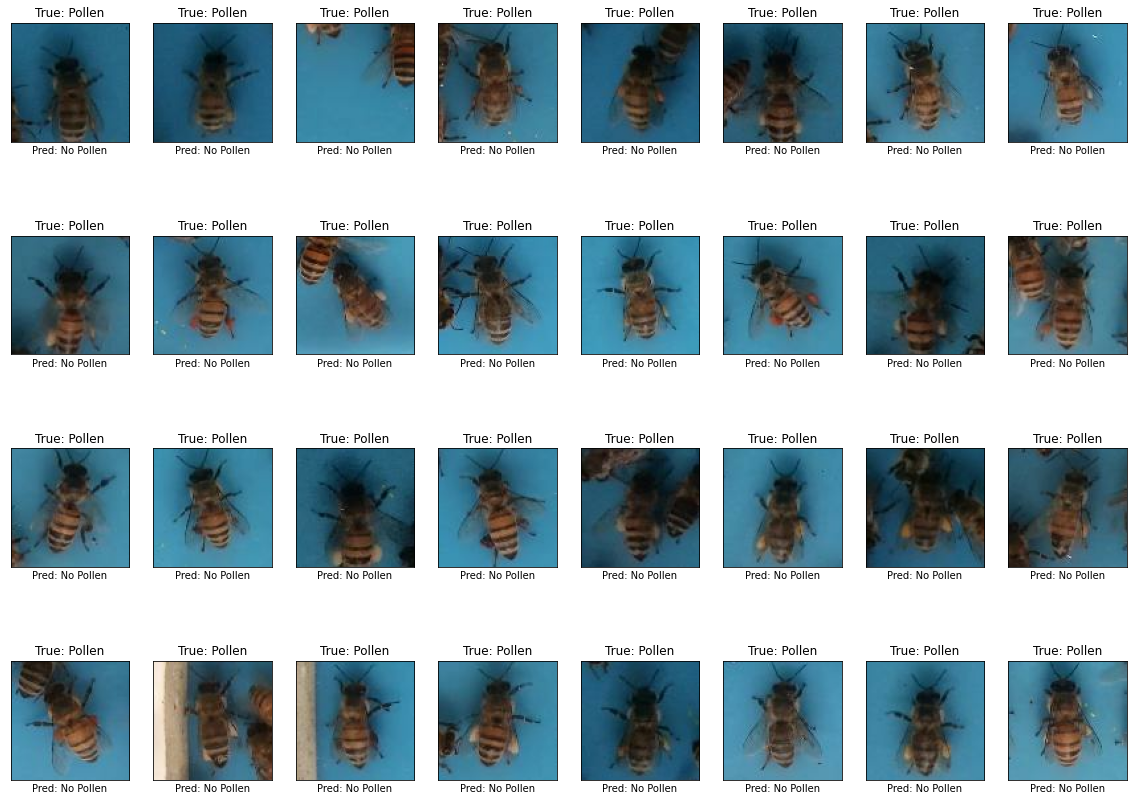

In [37]:
errors = (correct_labels - predicted_labels)**2
hard_cases_indxes = tf.argsort(errors, direction="DESCENDING", axis=0)
hard_cases_indxes = tf.reshape(hard_cases_indxes, -1)

fig, ax = plt.subplots(4, 8, figsize=(20, 15))
axes = ax.ravel()

for i, idx in enumerate(hard_cases_indxes[:32]):
    axes[i].imshow(images[idx])
    true_label = "Pollen" if correct_labels[idx] > 0.5 else "No Pollen"
    pred_label = "Pollen" if predicted_labels[idx] > 0.5 else "No Pollen"
    
    title = true_label + pred_label
    axes[i].set_title("True: {}".format(true_label))
    axes[i].set_xlabel("Pred: {}".format(pred_label))
    axes[i].set_xticks([])
    axes[i].set_yticks([])